In [ ]:
import pandas as pd
import warnings as wn
wn.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
df_combined = pd.read_csv('/content/drive/MyDrive/cleaned_online_fraud.csv')
df_combined.shape

(1908786, 11)

In [ ]:
df_combined['isFraud'].value_counts()

,count
isFraud,
0,1906322
1,2464


In [ ]:
X = df_combined.drop('isFraud', axis=1)
y = df_combined['isFraud']
X_resampled, y_resampled = SMOTE().fit_resample(X, y) #SMOTE application

X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=2)
# 60% data taken for training
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=2)
#20% data taken for validation and 20% taken for testing

X_train_sub = X_train.sample(n=100000, random_state=2) #downsampling data for hyperparameter tuning
y_train_sub = y_train.loc[X_train_sub.index]

print("Distibution of classes in the target column before the application of SMOTE:", Counter(y))
print("Distibution of classes in the target column after the application of SMOTE:", Counter(y_resampled))
print(f"""
Online Fraud Prediction Dataset Split:
- Training Samples   : {X_train.shape}
- Validation Samples : {X_val.shape}
- Testing Samples    : {X_test.shape}
""")

Distibution of classes in the target column before the application of SMOTE: Counter({0: 1906322, 1: 2464})
Distibution of classes in the target column after the application of SMOTE: Counter({0: 1906322, 1: 1906322})

Online Fraud Prediction Dataset Split:
- Training Samples   : (2287586, 10)
- Validation Samples : (762529, 10)
- Testing Samples    : (762529, 10)



**Logistic Regression with SMOTE**

In [ ]:
lr_model = LogisticRegression()

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10],
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear', 'saga']}

lr_grid_search = GridSearchCV(lr_model, param_grid, cv=2, scoring='accuracy')
lr_grid_search.fit(X_train_sub, y_train_sub)
lr_bst_param = lr_grid_search.best_params_
print("Best parameters of LR: ", lr_bst_param)
print("Best cross-validation score: {:.2f}".format(lr_grid_search.best_score_))

Best parameters of LR:  {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.96



Training time for LR: 953.6579 sec.
LR Training Accuracy: 0.9598
              precision    recall  f1-score   support

           0       0.96      0.96      0.96    380890
           1       0.96      0.96      0.96    381639

    accuracy                           0.96    762529
   macro avg       0.96      0.96      0.96    762529
weighted avg       0.96      0.96      0.96    762529



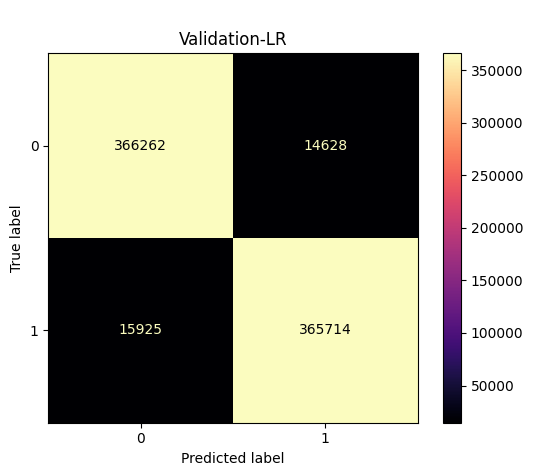

              precision    recall  f1-score   support

           0       0.96      0.96      0.96    381397
           1       0.96      0.96      0.96    381132

    accuracy                           0.96    762529
   macro avg       0.96      0.96      0.96    762529
weighted avg       0.96      0.96      0.96    762529



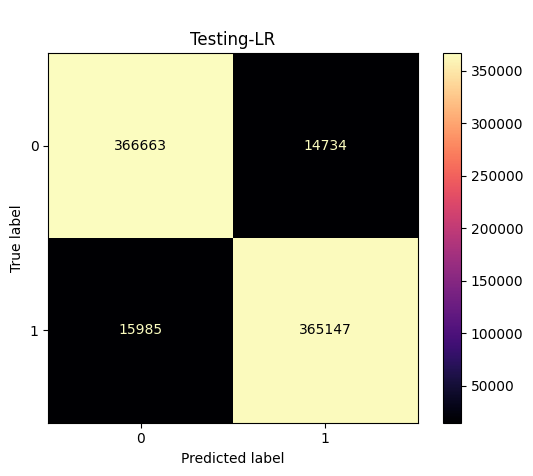

In [ ]:
time_start = time.time()
best_lr_model = LogisticRegression(**lr_bst_param)
best_lr_model.fit(X_train, y_train)
time_end = time.time()
time_train = time_end - time_start
print(f"\nTraining time for LR: {time_train:.4f} sec.")
accuracy_train = best_lr_model.score(X_train, y_train)
print(f"LR Training Accuracy: {accuracy_train:.4f}")

#------ Predicting on the validation samples
y_pred_val = best_lr_model.predict(X_val)
print(classification_report(y_val, y_pred_val))
cm_val = confusion_matrix(y_val, y_pred_val)
ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=[0, 1]).plot(cmap='magma')
plt.title('\nValidation-LR')
plt.show()

#------ Predicting on the testing samples
y_pred_test = best_lr_model.predict(X_test)
print(classification_report(y_test, y_pred_test))
cm_test = confusion_matrix(y_test, y_pred_test)
ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[0, 1]).plot(cmap='magma')
plt.title('\nTesting-LR')
plt.show()

**Random Forest with SMOTE**

In [ ]:
rf_model = RandomForestClassifier()

param_grid = {'n_estimators': [50, 80, 100],
              'max_depth': [3, 5, 8],
              'min_samples_split': [5, 10],
              'min_samples_leaf': [2, 4, 6],
              'max_features': ['sqrt', 'log2']}

rf_grid_search = GridSearchCV(rf_model, param_grid, cv=2, scoring='accuracy')
rf_grid_search.fit(X_train_sub, y_train_sub)
rf_bst_param = rf_grid_search.best_params_
print("Best parameters of RF: ", rf_bst_param)
print("Best cross-validation score: {:.2f}".format(rf_grid_search.best_score_))

Best parameters of RF:  {'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score: 0.99



Training time for RF: 603.1929 sec.
RF Training Accuracy: 0.9867
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    380890
           1       0.98      1.00      0.99    381639

    accuracy                           0.99    762529
   macro avg       0.99      0.99      0.99    762529
weighted avg       0.99      0.99      0.99    762529



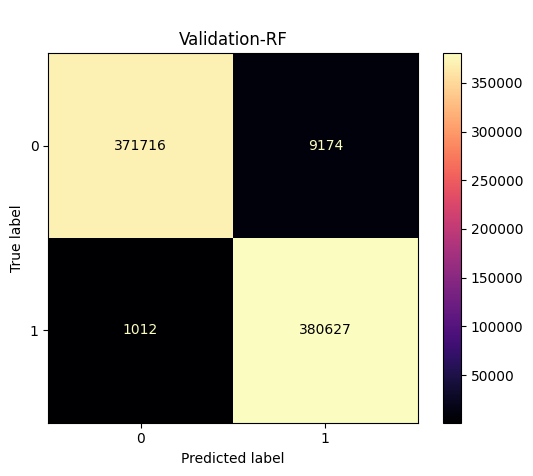

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    381397
           1       0.98      1.00      0.99    381132

    accuracy                           0.99    762529
   macro avg       0.99      0.99      0.99    762529
weighted avg       0.99      0.99      0.99    762529



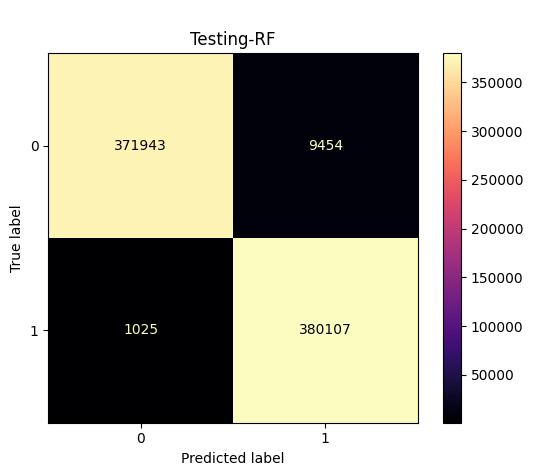

In [ ]:
time_start = time.time()
best_rf_model = RandomForestClassifier(**rf_bst_param)
best_rf_model.fit(X_train, y_train)
time_end = time.time()
time_train = time_end - time_start
print(f"\nTraining time for RF: {time_train:.4f} sec.")
accuracy_train = best_rf_model.score(X_train, y_train)
print(f"RF Training Accuracy: {accuracy_train:.4f}")

#------ Predicting on the validation samples
y_pred_val = best_rf_model.predict(X_val)
print(classification_report(y_val, y_pred_val))
cm_val = confusion_matrix(y_val, y_pred_val)
ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=[0, 1]).plot(cmap='magma')
plt.title('\nValidation-RF')
plt.show()

#------ Predicting on the testing samples
y_pred_test = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred_test))
cm_test = confusion_matrix(y_test, y_pred_test)
ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[0, 1]).plot(cmap='magma')
plt.title('\nTesting-RF')
plt.show()

**Decision Tree with SMOTE**

In [ ]:
dt_model = DecisionTreeClassifier()

param_grid = {'criterion':['gini', 'entropy'],
              'max_depth': [3, 5, 8],
              'min_samples_split': [5, 10],
              'min_samples_leaf': [2, 4, 6],
              'max_features': ['sqrt', 'log2']}

dt_grid_search = GridSearchCV(dt_model, param_grid, cv=2, scoring='accuracy')
dt_grid_search.fit(X_train_sub, y_train_sub)
dt_bst_param = dt_grid_search.best_params_
print("Best parameters of DT: ", dt_bst_param)
print("Best cross-validation score: {:.2f}".format(dt_grid_search.best_score_))

Best parameters of DT:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5}
Best cross-validation score: 0.98



Training time for DT: 11.4442 sec.
DT Training Accuracy: 0.9619
              precision    recall  f1-score   support

           0       0.99      0.94      0.96    380890
           1       0.94      0.99      0.96    381639

    accuracy                           0.96    762529
   macro avg       0.96      0.96      0.96    762529
weighted avg       0.96      0.96      0.96    762529



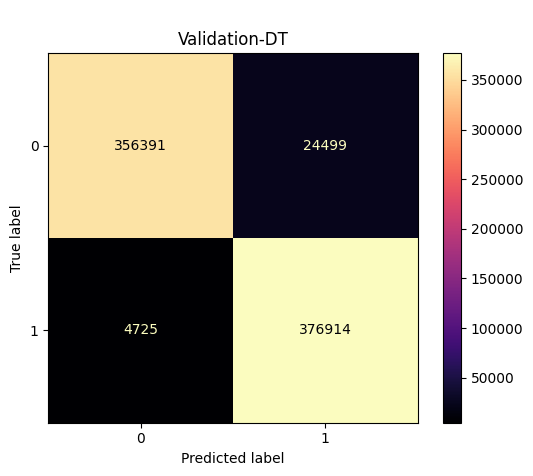

              precision    recall  f1-score   support

           0       0.99      0.94      0.96    381397
           1       0.94      0.99      0.96    381132

    accuracy                           0.96    762529
   macro avg       0.96      0.96      0.96    762529
weighted avg       0.96      0.96      0.96    762529



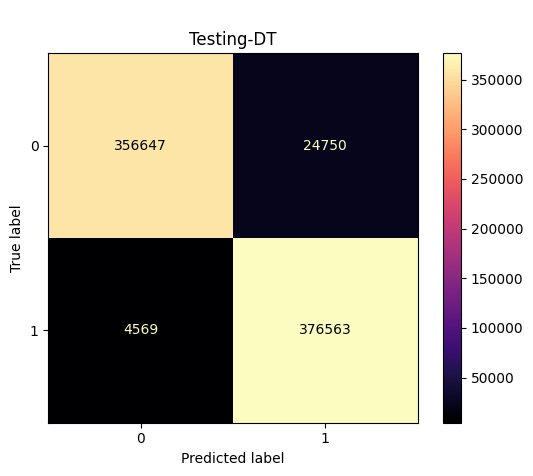

In [ ]:
time_start = time.time()
best_dt_model = DecisionTreeClassifier(**dt_bst_param)
best_dt_model.fit(X_train, y_train)
time_end = time.time()
time_train = time_end - time_start
print(f"\nTraining time for DT: {time_train:.4f} sec.")
accuracy_train = best_dt_model.score(X_train, y_train)
print(f"DT Training Accuracy: {accuracy_train:.4f}")

#------ Predicting on the validation samples
y_pred_val = best_dt_model.predict(X_val)
print(classification_report(y_val, y_pred_val))
cm_val = confusion_matrix(y_val, y_pred_val)
ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=[0, 1]).plot(cmap='magma')
plt.title('\nValidation-DT')
plt.show()

#------ Predicting on the testing samples
y_pred_test = best_dt_model.predict(X_test)
print(classification_report(y_test, y_pred_test))
cm_test = confusion_matrix(y_test, y_pred_test)
ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[0, 1]).plot(cmap='magma')
plt.title('\nTesting-DT')
plt.show()

**KNN with SMOTE**

In [ ]:
knn_model = KNeighborsClassifier()

param_grid = {'n_neighbors': [5, 7],
              'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree']}

knn_grid_search = GridSearchCV(knn_model, param_grid, cv=2, scoring='accuracy')
knn_grid_search.fit(X_train_sub, y_train_sub)
knn_bst_param = knn_grid_search.best_params_
print("Best parameters of KNN: ", knn_bst_param)
print("Best cross-validation score: {:.2f}".format(knn_grid_search.best_score_))

Best parameters of KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 0.97


In [ ]:
X_val_sub = X_val.sample(n=30000, random_state=2)
y_val_sub = y_val.loc[X_val_sub.index]
X_test_sub = X_test.sample(n=30000, random_state=2)
y_test_sub = y_test.loc[X_test_sub.index]

In [ ]:
y_test_sub.value_counts()

,count
isFraud,
0,15059
1,14941



Training time for KNN: 0.1661 sec.
KNN Training Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     14880
           1       0.96      1.00      0.98     15120

    accuracy                           0.98     30000
   macro avg       0.98      0.98      0.98     30000
weighted avg       0.98      0.98      0.98     30000



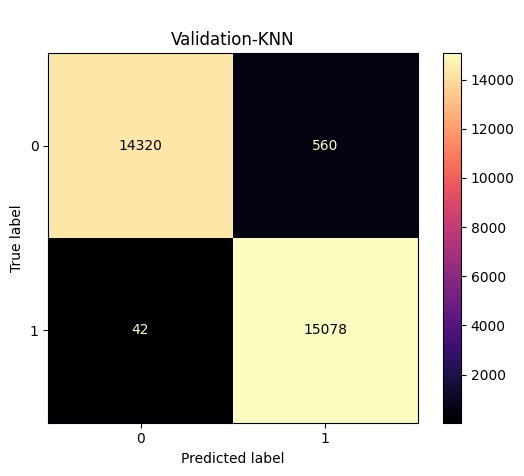

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15059
           1       0.96      1.00      0.98     14941

    accuracy                           0.98     30000
   macro avg       0.98      0.98      0.98     30000
weighted avg       0.98      0.98      0.98     30000



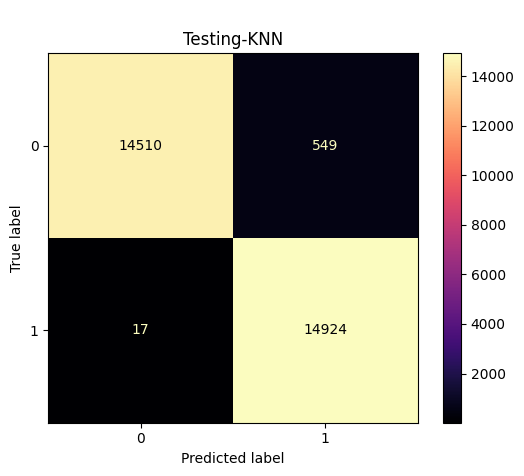

In [ ]:
time_start = time.time()
best_knn_model = KNeighborsClassifier(**knn_bst_param)
best_knn_model.fit(X_train_sub, y_train_sub)
time_end = time.time()
time_train = time_end - time_start
print(f"\nTraining time for KNN: {time_train:.4f} sec.")
accuracy_train = best_knn_model.score(X_train_sub, y_train_sub)
print(f"KNN Training Accuracy: {accuracy_train:.4f}")

#------ Predicting on the validation samples
y_pred_val = best_knn_model.predict(X_val_sub)
print(classification_report(y_val_sub, y_pred_val))
cm_val = confusion_matrix(y_val_sub, y_pred_val)
ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=[0, 1]).plot(cmap='magma')
plt.title('\nValidation-KNN')
plt.show()

#------ Predicting on the testing samples
y_pred_test = best_knn_model.predict(X_test_sub)
print(classification_report(y_test_sub, y_pred_test))
cm_test = confusion_matrix(y_test_sub, y_pred_test)
ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[0, 1]).plot(cmap='magma')
plt.title('\nTesting-KNN')
plt.show()